Initial shape: (32581, 12)
After removing duplicates: (32416, 12)
After removing missing targets: (32416, 12)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5066
           1       0.97      0.72      0.83      1418

    accuracy                           0.93      6484
   macro avg       0.95      0.86      0.89      6484
weighted avg       0.94      0.93      0.93      6484


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5066
           1       0.93      0.65      0.77      1418

    accuracy                           0.91      6484
   macro avg       0.92      0.82      0.86      6484
weighted avg       0.91      0.91      0.91      6484


Model Performance Comparison:
               accuracy  recall  precision      f1     auc
Random Forest    0.9334  0.7186     0.9686  0.8251  0.9288
SVM              0.91

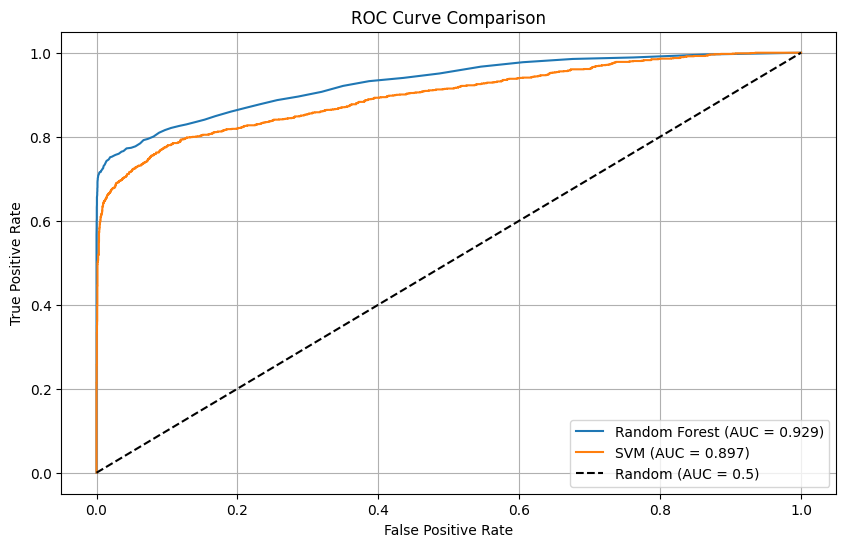

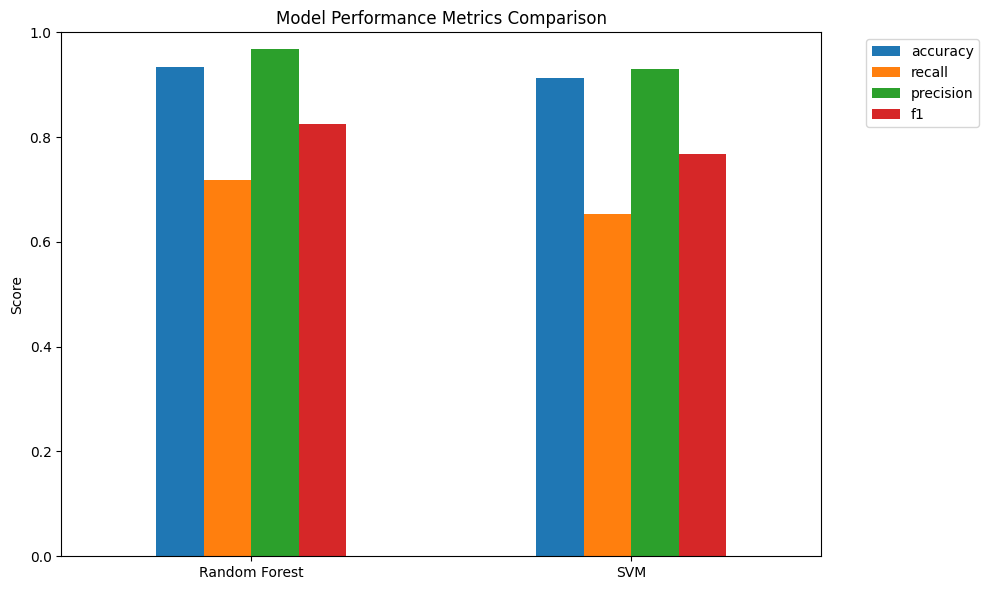

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, roc_curve,
                             accuracy_score, recall_score,
                             precision_score, f1_score,
                             classification_report)

# Load and clean data
df = pd.read_csv("credit_risk_dataset.csv")

# Data cleaning steps
print("Initial shape:", df.shape)

# Remove duplicates
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

# Handle missing target values
df = df[df['loan_status'].notna()]
print("After removing missing targets:", df.shape)

# Define features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Column types
categorical_cols = [
    'person_home_ownership', 'loan_intent',
    'loan_grade', 'cb_person_default_on_file'
]

numerical_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Models to compare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Results storage
results = {}

# Train and evaluate models
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'fpr': roc_curve(y_test, y_proba)[0],
        'tpr': roc_curve(y_test, y_proba)[1]
    }

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Create metrics comparison table
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df = metrics_df[['accuracy', 'recall', 'precision', 'f1', 'auc']]
print("\nModel Performance Comparison:")
print(metrics_df.round(4))

# ROC Curve Plot
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    plt.plot(result["fpr"], result["tpr"],
             label=f"{model_name} (AUC = {result['auc']:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Metrics Comparison Plot
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.drop('auc', axis=1).plot(kind='bar', ax=ax)
plt.title("Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()